In [2]:
from pathlib import Path

import numpy as np
import xarray as xr
from ILAMB import ilamblib
import regionmask as rgn

In [2]:
indir = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed/annual_mean'

lai_avh15c1 = xr.open_dataset(f'{indir}/LAI_ANNUAL_AVH15C1_ILAMB_20250709.nc')
lai_avhrr = xr.open_dataset(f'{indir}/LAI_ANNUAL_AVHRR_ILAMB_20250709.nc')
lai_cao2023 = xr.open_dataset(f'{indir}/LAI_ANNUAL_CAO2023_ILAMB_20250709.nc')
lai_modis = xr.open_dataset(f'{indir}/LAI_ANNUAL_MODIS_ILAMB_20250709.nc')


lai = {
    'AVH15C1': lai_avh15c1,
    'AVHRR': lai_avhrr,
    'CAO2023': lai_cao2023,
    'MODIS': lai_modis,
}

# Load the land mask from the Natural Earth dataset
land = rgn.defined_regions.natural_earth_v5_1_2.land_50

# Compute the cell areas for each dataset then extract the ET variable
area = {}
lnd_area = {}
for key, ds in lai.items():
    print(key)

    if 'lat_bounds' in ds and 'lon_bounds' in ds:
        print('  using bounds')
        method = 'bounds'
        lat_bounds = ds['lat_bounds'].values
        lon_bounds = ds['lon_bounds'].values
    else:
        print('  could not find bounds, using coordinates instead')
        method = 'coords'
        lat_bounds = None
        lon_bounds = None

    # Compute the cell areas using the ILAMB function
    area[key] = ilamblib.CellAreas(
                    lat=ds['lat'].values,
                    lon=ds['lon'].values,
                    lat_bnds=lat_bounds,
                    lon_bnds=lon_bounds,
                )

    area[key] = xr.DataArray(area[key], dims=['lat', 'lon'], coords={'lat': ds['lat'], 'lon': ds['lon']})
    area[key].attrs['units'] = 'm2'
    area[key].attrs['long_name'] = 'grid cell area'
    area[key].attrs['method'] = method
    
    # Create a land mask for the dataset using the Natural Earth land mask
    lnd_mask = xr.where(np.isnan(land.mask(lon_or_obj=area[key].lon, lat=area[key].lat)), 0, 1)
    lnd_area[key] = area[key] * lnd_mask
    lnd_area[key].attrs['units'] = 'm2'
    lnd_area[key].attrs['long_name'] = 'land grid cell area'
    lnd_area[key].attrs['method'] = method

    # Extract the LAI variable from each dataset
    lai[key] = ds['lai'].where(lnd_mask > 0)

AVH15C1
  using bounds
AVHRR
  could not find bounds, using coordinates instead
CAO2023
  could not find bounds, using coordinates instead
MODIS
  could not find bounds, using coordinates instead


In [9]:
start_year = 2003
end_year = 2009
year_slice = slice(start_year, end_year)
print(f'{start_year} to {end_year}')

ilat = lai['AVHRR'].lat.values  # use the lat values from AVHRR for interpolation

lai_savg = {}
lai_zavg = {}
lai_izavg = {}

# Full temporal averages (all years for each dataset)
lai_tavg_full = {}
lai_tzavg_full = {}
lai_itzavg_full = {}

# Temporal averages for the specified year range (overlapping time period only)
lai_tavg_overlap = {}
lai_tzavg_overlap = {}
lai_itzavg_overlap = {}

for key in lai.keys():
    # Compute the global average
    lai_savg[key] = (lai[key] * lnd_area[key]).sum(dim=['lat', 'lon']) / lnd_area[key].sum(dim=['lat', 'lon'])

    # Compute the zonal averages
    lai_zavg[key] = lai[key].mean(dim='lon')

    # Interpolate the zonal average to a 1deg lat grid
    lai_izavg[key] = lai_zavg[key].interp(lat=ilat, method='linear')

    # Compute the temporal average for the full dataset
    lai_tavg_full[key] = lai[key].mean(dim='year')
    lai_tzavg_full[key] = lai_tavg_full[key].mean(dim='lon')
    lai_itzavg_full[key] = lai_tzavg_full[key].interp(lat=ilat, method='linear')
    
    # Compute the temporal average for the specified year range
    if (start_year in lai[key].year) and (end_year in lai[key].year):
        lai_tavg_overlap[key] = lai[key].sel(year=year_slice).mean(dim='year')

        # Compute the temporal and zonal average
        lai_tzavg_overlap[key] = lai_tavg_overlap[key].mean(dim='lon')
        lai_itzavg_overlap[key] = lai_tzavg_overlap[key].interp(lat=ilat, method='linear')
    else:
        print('skipping temporal average for', key)

# Create a DataArray from the lai_itzavg_overlap dictionary
datasets = list(lai_itzavg_overlap.keys())
data = [lai_itzavg_overlap[ds].values for ds in datasets]
lai_itzavg_overlap_da = xr.DataArray(
    data,
    dims=['dataset', 'lat'],
    coords={'dataset': datasets, 'lat': ilat},
    name='lai_itzavg_overlap',
    attrs={
        'units': 'm2 m-2',
        'standard_name': 'leaf_area_index',
        'long_name': 'leaf area index',
    }
)

2003 to 2009
skipping temporal average for MODIS


In [10]:
OUTDIR_ZM = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed/zonal_mean'
lai_itzavg_overlap_da.to_netcdf(f'{OUTDIR_ZM}/LAI_ZONAL_MEAN_ILAMB_{start_year}-{end_year}.nc')

OUTDIR_GM = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed/global_mean'
for key in lai_savg.keys():
    lai_savg[key].rename(f'lai_{key}').to_netcdf(f'{OUTDIR_GM}/LAI_GLOBAL_MEAN_{key}_ILAMB.nc')

In [6]:
indir = Path('/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/raw')

products = [
    'AVH15C1',
    'AVHRR',
    'CAO2023',
    # 'MODIS',
]

lai_ds = {}
for p in products:
    lai_ds[p] = xr.open_dataset(indir / f'LAI_{p}_ILAMB_20250709.nc')

# Load the land mask from the Natural Earth dataset
land = rgn.defined_regions.natural_earth_v5_1_2.land_50

# Compute the cell areas for each dataset then extract LAI
area = {}
lnd_area = {}
for p in products:
    print(p)
    
    ds = lai_ds[p]

    if 'lat_bounds' in ds and 'lon_bounds' in ds:
        print('  using bounds')
        method = 'bounds'
        lat_bounds = ds['lat_bounds'].values
        lon_bounds = ds['lon_bounds'].values
    else:
        print('  could not find bounds, using coordinates instead')
        method = 'coords'
        lat_bounds = None
        lon_bounds = None

    # Compute the cell areas using the ILAMB function
    area[p] = ilamblib.CellAreas(
                    lat=ds['lat'].values,
                    lon=ds['lon'].values,
                    lat_bnds=lat_bounds,
                    lon_bnds=lon_bounds,
                )

    area[p] = xr.DataArray(area[p], dims=['lat', 'lon'], coords={'lat': ds['lat'], 'lon': ds['lon']})
    area[p].attrs['units'] = 'm2'
    area[p].attrs['long_name'] = 'grid cell area'
    area[p].attrs['method'] = method
    
    # Create a land mask for the dataset using the Natural Earth land mask
    lnd_mask = xr.where(np.isnan(land.mask(lon_or_obj=area[p].lon, lat=area[p].lat)), 0, 1)
    lnd_area[p] = area[p] * lnd_mask
    lnd_area[p].attrs['units'] = 'm2'
    lnd_area[p].attrs['long_name'] = 'land grid cell area'
    lnd_area[p].attrs['method'] = method



lai_mn = {}
lai_yr = {}
lai_yr_gm = {}
for p in products:
    lai_mn[p] = lai_ds[p].lai
    lai_yr[p] = lai_mn[p].groupby('time.year').map(lambda x: x.weighted(x.time.dt.days_in_month).mean(dim="time"))
    lai_yr_gm[p] = lai_yr[p].weighted(lnd_area[p]).mean(dim=['lat', 'lon'])

AVH15C1
  using bounds
AVHRR
  could not find bounds, using coordinates instead
CAO2023
  could not find bounds, using coordinates instead


In [9]:
outdir_gm = '/glade/work/bbuchovecky/CPL_PPE_CO2/select_parameters/ILAMB_data/processed/global_mean'
for p in products:
    lai_yr_gm[p].rename(f'lai_{p}').to_netcdf(f'{outdir_gm}/LAI_GLOBAL_MEAN_{p}_ILAMB.nc')

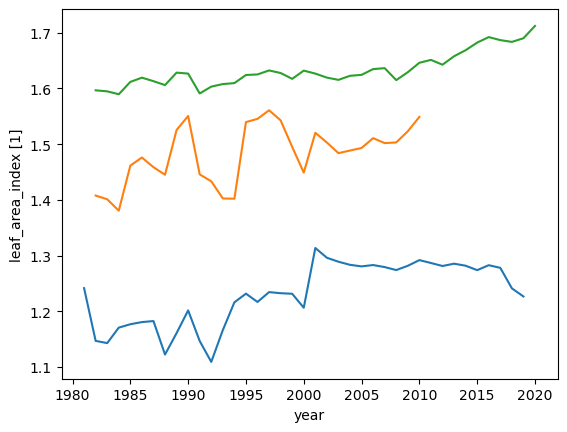

In [10]:
for p in products:
    lai_yr_gm[p].plot()